# 13. Tree Search with Policy on Connect 4

## Mock4

Mock4 모듈을 불러옵니다.

In [1]:
!rm -rf mock4.py m4
!git clone https://github.com/lumiknit/mock4.py.git
!mv mock4.py m4
!mv m4/mock4.py .
import mock4
from mock4 import Mock4

Cloning into 'mock4.py'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 28 (delta 8), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

-----------------
[ Turn  27 ; 2P ]
| 0 1 2 3 4 5 6 |
| . . . . . . . |
| . X O O . X . |
| O O O O . X . |
| O O X X . O . |
| X X O O . O O |
| X X X O X X X |
1P Win (greedy)


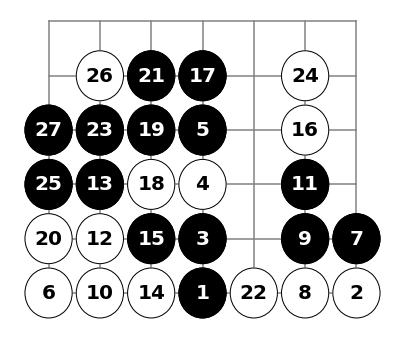

In [3]:
test_game = Mock4()
test_game.play(mock4.agent_random, mock4.agent_greedy, p_msg=False)
test_game.plot()
plt.show()
plt.close()

시작하기 전에 temperatured softmax를 정의하고 갑니다.

In [4]:
def softmax(arr, tau=1.0):
  arr = np.array(arr, dtype=np.float64)
  arr /= tau
  m = max(arr)
  z = np.exp(arr - m)
  return z / z.sum()

In [5]:
print("softmax([1, 2, 3]) with tau = {} => {}".format(0.1, softmax([1, 2, 3], 0.1)))
print("softmax([1, 2, 3]) with tau = {} => {}".format(1, softmax([1, 2, 3], 0.5)))
print("softmax([1, 2, 3]) with tau = {} => {}".format(10, softmax([1, 2, 3], 10)))

softmax([1, 2, 3]) with tau = 0.1 => [2.06106005e-09 4.53978686e-05 9.99954600e-01]
softmax([1, 2, 3]) with tau = 1 => [0.01587624 0.11731043 0.86681333]
softmax([1, 2, 3]) with tau = 10 => [0.30060961 0.33222499 0.3671654 ]


## Agent와 Policy

강화학습은 '특정 environment에서 agent가 특정 policy를
바탕으로 행동한다'는 조건 아래에서
reward를 최대로 하는 policy를 찾는 것을 목표로 합니다.
이 policy는 state에 따라 항상 확정되는
deterministic policy일 수도 있고,
각 행동을 할 확률을 나타내는
stochastic policy일 수도 있습니다.

Deterministic policy $\pi_D$가 있다면, 이와 동일한
stochastic policy $\pi$는 $\pi = \mathbb{1}_{\{(s, \pi_D(s)) \mid s \in S\}}$와 같이 구성할 수
있습니다.
하지만 stochastic policy는 결정적이지 않을 수 있어서
역방향으로 변환은 힘들 수 있습니다.

다만, stochastic policy를 바탕으로 deterministic하게
행동하는 것은 가능합니다. 예를 들어서 $\pi$의 분포가
$\pi^*$에 가깝다면 $\pi$에 따라 행동을 해도
(충분히 많은 시간이 지나면 분포가) $\pi^*$에 가깝게
행동이 될 것이며, 만약 optimal policy가 determinisitc
이고 $\pi$의 가장 큰 확률을 갖는 행동 $a$에 대해
$\pi^*(s) = a$를 만족한다는 기대가 있으면,
$\pi^\text{max}(s) = \text{argmax}_{a \in A} \pi(a | s)$에 따라 deterministic하게
행동할 수 있습니다.
(물론 policy가 최대의 확률을 갖는다는 것이
그 행동이 최선의 선택이라는 것은 아니므로 해석을
잘 할 필요는 있습니다.)

예를 들어서 `Mock4`에서
7개의 열을 선택하는 것을 action space라고 했을 때,
임의의 stochastic policy에서 행동을 결정하는 것은
다음과 같이 할 수 있습니다.
($\epsilon$은 random exploration용 parameter입니다.)

In [6]:
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.w, game.h
    m, p = np.ones(game.w), np.array(pi(game))
    for i in range(game.w):
      if game.board[(i + 1) * h - 1] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None # Cannot do anything
      else: return np.random.choice(w, p=(m / s))
    else: return np.random.choice(w, p=(p / s))
  name = str(pi)
  if hasattr(pi, 'name'): name = pi.name
  c.name = "stochastic({})".format(name)
  return c

예를 들어서 아래와 같이 확률을 테스트해볼 수 있습니다.

In [7]:
m = Mock4()
for i in range(m.h): m.place(3)
p = [0, 2, 10, 10, 5, 1, 0]
e = [0, 2, 10, 0, 5, 1, 0] # [3] will not be chosen because it's filled
result = [0] * m.w
ag = agent(lambda s: p)
N = 1000
for i in range(N):
  a = ag(m)
  if a is None: print("NONE")
  else: result[a] += 1
for i in range(m.w):
  print("C={} chosen {:4d} times (P={:.3f}, expected {:.3f})".format(
      i, result[i], result[i] / N, (e[i] / sum(e))))

C=0 chosen    0 times (P=0.000, expected 0.000)
C=1 chosen  111 times (P=0.111, expected 0.111)
C=2 chosen  560 times (P=0.560, expected 0.556)
C=3 chosen    0 times (P=0.000, expected 0.000)
C=4 chosen  269 times (P=0.269, expected 0.278)
C=5 chosen   60 times (P=0.060, expected 0.056)
C=6 chosen    0 times (P=0.000, expected 0.000)


이제 이를 바탕으로 기존에 사용하였던 일부 agent를
만들어볼 수 있습니다.

예를 들어서 `agent_random`은 빈칸이 있는 열들에 대해
동일한 확률로 돌을 둡니다.
즉, policy는 state와 무관하게 uniform
distribution을 가지게 되므로,

In [8]:
def policy_uniform(game):
   return [1] * game.w
policy_uniform.name = 'uniform'

라고 할 수 있으며, 이를 바탕으로 agent_random을
다음과 같이 구현할 수 있습니다.

In [9]:
agent_random = agent(policy_uniform)

In [10]:
mock4.test_mock4(100, agent_random, mock4.agent_random)

** Test
* A1 = stochastic(uniform)
* A2 = random
Total = 100 games
W1 45 (0.450) / Dr 1 (0.010) / W2 54 (0.540)


`agent_greedy`의 경우에는
현재 판의 연결 성분들을 분석해서 상대의 방해가 없는 경우
몇 수 뒤에 게임을 끝낼 수 있는지 추정한 뒤,
이를 바탕으로 점수를 매기는 함수
`policy_greedy_connect`를 사용합니다.
(이 함수는 0 초과 1 미만을 반환하며,
연결 성분이 길수록, 많을수록 1에 가깝습니다.)

In [11]:
m = Mock4()
for i in range(7): m.place(mock4.agent_greedy(m))
print(m)
print(mock4.policy_greedy_connect(m))

[ Turn   7 ; 2P ]
| 0 1 2 3 4 5 6 |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . . . . . |
| . . . X O . . |
| . . X O O O X |
[0.0002816  0.00028738 0.00258468 0.01367391 0.02607264 0.00175199
 0.00101378]


주의해야할 점은 이 값들은 승률 같은 확률이 아니라 점수라는
것입니다. 즉, 실제 높은 값을 갖는 위치에 돌을 두면
돌을 연결하는 것에 관한 점수가 높아지는 것이지,
높은 승률을 보장하지는 않습니다.
하지만, 돌을 길게 이어야 승리하는 게임인 만큼
점수가 큰 행동을 취하는 것이 유리합니다.

이를 바탕으로 아래와 같은 agent를 만들 수 있습니다.

In [12]:
mock4.policy_greedy_connect.name = 'greedy'
agent_connect = agent(mock4.policy_greedy_connect)

In [13]:
mock4.test_mock4(1000, mock4.agent_greedy, agent_connect)

** Test
* A1 = greedy
* A2 = stochastic(greedy)
Total = 1000 games
W1 785 (0.785) / Dr 21 (0.021) / W2 194 (0.194)


`agent_connect`는 점수가 높을수록 해당 action을
선택하려고 하지만, `agent_greedy`와는 다르게
항상 최대 점수가 되는 칸을 선택하지는 않기 때문에
임의의 선택을 할 가능성이 큽니다.

만약에 policy가 neural network로 구현되었다고 하면
위 `agent`에 해당 game을 neural network의
입력으로 변환한 뒤 실행하도록 하면
policy network에 대한 agent를 만들 수 있습니다.

## Policy Transformer

위에서 누누히 policy는 행동을 할 확률을 나타내지,
점수나 승률 등을 나타내지는 않는다고 하였습니다.
하지만, 어떤 policy가 나름 reward를 최대화 하기 위해
만들어졌다면, policy로 나온 확률을 일종의 고득점을
위한 지표로 생각해볼 수 있을 것입니다.
그리고 이 지표를 바탕으로 새로운 policy를 만들어낼 수
있는데, 여기서는 이것을 policy transformer라고
가칭하도록 하고,
접두사로 `pt_`가 붙은 함수들이 transformer입니다.

예를 들어서 임의의 policy에 대해,
해당 policy에서 가장 확률이 높은 선택지만
고르는 policy를 만들어볼 수 있습니다.

In [14]:
def pt_greedy(policy):
  def p(game):
    p = policy(game)
    m = None
    for c in range(game.w):
      if game.board[(c + 1) * game.h - 1] == 0 and (m is None or p[m] < p[c]):
        m = c
    for c in range(game.w):
      p[c] = 1 if c == m else 0
    return p
  p.name = 'pt_greedy({})'.format(mock4.agent_name(policy))
  return p

In [15]:
agent_greedy_connect = agent(pt_greedy(mock4.policy_greedy_connect))

In [16]:
mock4.test_mock4(100, mock4.agent_greedy, agent_greedy_connect)

** Test
* A1 = greedy
* A2 = stochastic(pt_greedy(greedy))
Total = 100 games
W1 46 (0.460) / Dr 0 (0.000) / W2 54 (0.540)


위의 `agent_greedy_connect`와 `mock4.agent_greedy`
모두 `policy_greedy_connect`를 최대화하는
policy를 사용하기 때문에, 승률이 거의 반반이 나오는
것을 볼 수 있습니다.

외에도 가운데에 돌을 유리하다는 가정으로,
중앙에 조금 더 점수를 주는 transformer를 
만들어볼 수 있습니다.

In [17]:
def pt_center(policy):
  def p(game):
    p = policy(game)
    for c in range(game.w):
      p[c] *= (1 - 0.1 * abs(c - game.w // 2))
    return p
  p.name = 'pt_center({})'.format(mock4.agent_name(policy))
  return p

In [18]:
a = agent(pt_center(policy_uniform))
mock4.test_mock4(1000, agent_random, a)
# a is slightly better than normal agent_random

** Test
* A1 = stochastic(uniform)
* A2 = stochastic(pt_center(uniform))
Total = 1000 games
W1 450 (0.450) / Dr 3 (0.003) / W2 547 (0.547)


Temperatured softmax 역시 transformer로
사용할 수 있으며, 이 경우에, parameter를 어떻게
두느냐에 따라 uniformly random에서 argmax까지
확률분포를 조절하는 것이 가능합니다.


In [19]:
def pt_softmax(policy, tau=1.0):
  def p(game):
    p = policy(game)
    return softmax(p, tau=tau)
  p_name = mock4.agent_name(policy)
  p.name = 'pt_softmax({},tau={})'.format(p_name, tau)
  return p

In [20]:
def agent_sm_greedy(tau):
  return agent(pt_softmax(mock4.policy_greedy_connect, tau=tau))
mock4.test_mock4(100, mock4.agent_greedy, agent_sm_greedy(tau=1e-1))
mock4.test_mock4(100, mock4.agent_greedy, agent_sm_greedy(tau=1e-3))
mock4.test_mock4(100, mock4.agent_greedy, agent_sm_greedy(tau=1e-6))
mock4.test_mock4(100, mock4.agent_greedy, agent_sm_greedy(tau=1e-9))

** Test
* A1 = greedy
* A2 = stochastic(pt_softmax(greedy,tau=0.1))
Total = 100 games
W1 98 (0.980) / Dr 0 (0.000) / W2 2 (0.020)
** Test
* A1 = greedy
* A2 = stochastic(pt_softmax(greedy,tau=0.001))
Total = 100 games
W1 66 (0.660) / Dr 4 (0.040) / W2 30 (0.300)
** Test
* A1 = greedy
* A2 = stochastic(pt_softmax(greedy,tau=1e-06))
Total = 100 games
W1 47 (0.470) / Dr 1 (0.010) / W2 52 (0.520)
** Test
* A1 = greedy
* A2 = stochastic(pt_softmax(greedy,tau=1e-09))
Total = 100 games
W1 48 (0.480) / Dr 0 (0.000) / W2 52 (0.520)


Temperatured softmax 특성상 $\tau$가 작아질수록
max 함수에 가까워지게 되고, 위 agent는
점수에 대해 greedy한 행동을 하는 `agent_greedy`에
가까워지게 됩니다.
반대로 $\tau$가 커질수록 randomness가 커지게 됩니다.

Randomness가 너무 높으면 좋지 못한 수를 선택할 가능성이
커지므로 실력이 줄어들지만,
반대로 randomness가 너무 낮으면 단순히 당장의 점수를
최대화하는 것 밖에 보지 못해 근시안적인 선택을 할 수
밖에 없어서 승률이 낮아집니다.

이렇게 policy에 약간의 소금과 설탕을 쳐주는
transformer도 여러가지 흥미로울 수 있지만,
여기서는 매우 강력한 transformer를 도입하고자 합니다.

## Tree Search with Policy

이전에 Tree Search와 Pruning에 대해 언급한 적이 있었습니다.
우리가 전체 트리를 가지고 있고, 이를 충분히 빠르게
탐색할 수 있으면, 최선의 선택을 반복하는 것이 가능하지만,
이것이 느리기 때문에 pruning을 사용해서 탐색하는 경우를 줄일 수
있고 아니면 Monte Carlo Method를 통해 근사를 하도록 합니다.

이번에는 여기서 pruning에 대해 생각해볼 것입니다.
만약에 tree가 높이 $d$에 자식의 개수를 $b$개 가지는 full tree
라면 이 트리의 모든 정점을 탐색하는 경우 $\Theta(b^d)$라는 시간이
걸리게 됩니다. 즉, 만약 최대 높이 $d$에 최대 자식의 개수가 $b$인
트리의 경우에 upper bound를 $O(b^d)$라고 할 수 있습니다.
결국 트리를 탐색하는 방법으로 답을 알고 싶다면, (1) 높이 $d$를
줄이거나, (2) 너비 $b$를 줄여야 합니다.

우리가 optimal action value function
$q^*$를 알고 있을 때 최적의 행동을 얻을 수 있는 것을
다음과 같이 해석할 수 있습니다.

- 어떤 상태 $s$와 행동 $a$가 있을 때, $q^*(s, a)$는
$s$에서 $a$를 했을 때 얻을 수 있는 최대 보상을 가집니다.
즉, $s$ 이후의 상태를 고려하지 않아도 이후 최댓값을
추정할 수 있으므로, $d=0$ 만큼만 탐색해도 충분함을 보장해줍니다.
- 어떤 상태 $s$가 있을 때, $q^*(s, a)$는 각 행동 $a$를
했을 때 얻을 수 있는 최대값을 나타내므로, 이 값이 최대가 되는
$a$ 외의 행동을 고려할 필요가 없습니다.
즉, $b=1$으로도 충분함을 보장합니다.

추가적으로, reward를 최대화하는 optimal deterministic
policy
$\pi^*$가 있는 경우에는
$q^*$를 모르더라도 현재 $s$에서의 최적의 행동을 알 수 있으므로,
2번째 해석을 아래와 같이 바꿀 수 있습니다.

- 어떤 상태 $s$가 있을 때, $\pi^*(s)$는 보상을 최대로 하는
행동이므로, 이외의 행동을 고려할 필요가 없습니다.
즉, $b=1$로도 충분합니다.

정리하자면, $q^*$는 일정 깊이 이상은 탐색하지 않아도 충분함을
보장하고, $\pi^*$는 일정 너비 이상 탐색하지 않아도 충분함을 보장합니다.

그런데, 실제로 이 $q^*$와 $\pi^*$를 가지고 있지 않다는 문제가
있습니다.



강화학습에서는 $q^*$와 $\pi^*$를 근사하는 함수를 구하는
것이 주요 목표이며, TD, Q-Learning 등으로 $q$를
근사하며, 이를 통해 $\pi$를 구하거나, Policy Gradient나
Actor-Critic 등의 방법으로 $\pi$를 근사하게 됩니다.

만약 $q$와 $\pi$가 충분히 근사되어 optimal function에
가까운 결과를 낸다고 하면, 이를 이용하여 tree search의
경우를 줄일 수 있지 않을까 생각해볼 수 있습니다.
예를 들어서,

- 만약 임의의 $s, a$에 대해 $q(s, a)$가 너무 작다면,
$q^*(s, a)$도 작을 것이라고 생각할 수 있으므로,
해당 action은 굳이 탐색할 가치가 없다고 볼 수 있습니다.
이 경우에 깊이나 너비를 제한할 수 있습니다.
- 만약 어떤 $s$가 있을 때, 임의의 $a$에 대해 $\pi(a|s)$가
너무 작다면, 해당 행동을 취해서 보상을 최대화할 확률이 매우
낮다고 추정할 수 있으며, 이런 선택지는 제외할 수 있습니다.
이 경우에 너비를 제한하는 것이 가능합니다.

이를 이용하면 아래와 같은 알고리즘을 생각해볼 수 있습니다.

```
opt(s)
  A = {s에서 가능한 행동}
  A' = a in A 중 policy(s, a)가 상위 n개에 들어가는 s의 집합
  for each a in A'
    for each p in P
      s' = s에서 a를 했을 때 전이되는 상태
      if s'가 최종상태
        v = 0
      elseif 탐색 깊이가 d보다 깊을 때
        v = max Q(s', a) for a
      else
        v = opt(s).value
    mean_v = R(s, a) + v의 P에 대한 weighted sum
  return.index = argmax mean_v
  return.value = max mean_v
```

즉, 각 상태에서 탐색할 행동의 수를 `policy`로 제한하고,
특정 깊이 이상 내려갈 때 `Q`를 통해 탐색 깊이를 제한합니다.

## Tree Search ONLY with Policy

현재는 REINFORCE 알고리즘으로 나름 괜찮은 policy를
얻는 것은 가능하지만, $q$를 얻는 것은 잘 되지 않고 있습니다.
나중에 Actor-Critic처럼 policy gradient로
$q$를 구하는 것을 생각해볼 수도 있겠지만,
현재는 $q$ 없이 policy만 존재한다고 해봅시다.

이 경우에 너비를 줄이는 것은 그대로 쓸 수 있지만, 깊이를 줄이는
것은 힘듭니다.
따라서, '비교적 유리하다고 평가하는 수'들만을 모두 따라갔을 때
최종적으로 어떻게 되는지를 확인해보고, 이를 바탕으로
행동을 결정하도록 해야합니다.
하지만, 중력4목도 깊이가 최대 42나 되므로,
만약 너비를 2로 제한한다고 해도
$2^42$개나 되는 경우를 고려해야 할 수 있습니다.

이를 해결하기 위해, 깊이를 제한하고, 게임이 종료되는 경우에는
reward를 이용해서 판단을 내리고,
게임이 종료되지 않으면 reward를 'unknown'으로 두도록 합니다.

이 방식은 policy와 매개변수를 받아서 처리하므로, policy
transformer처럼 나타낼 수 있습니다.

In [21]:
# Tree Search with Bound
def pt_tswb(policy, max_depth, max_breadth):
  def search(game, depth): # return (winner, action)
    # If game is terminated, just return the winner
    w = game.check_win()
    if w is not None or depth >= max_depth:
      if depth == 0: return w, policy(game)
      else: return w, None
    # Search
    # First, find policy
    p = policy(game)
    m_full = np.ones(len(p))
    m_lose = np.ones(len(p))
    m_win = np.zeros(len(p))
    m_searched = np.zeros(len(p))
    # Remove unavailable actions
    for c in range(game.w):
      if game.board[(c + 1) * game.h - 1] != 0:
        m_full[c] = 0
    # Sort policy
    s = sorted([(-x, i) for i, x in enumerate(p * m_full)])
    for mprob, i in s[:max_breadth]:
      if -mprob <= 0: break
      m_searched[i] = 1
      game.place(i)
      w, j = search(game, depth + 1)
      game.undo()
      if w == game.player: # If player win, we can win follow this.
        m_win[i] = 1
      elif w == 3 - game.player: # If player lose, we should not follow
        m_lose[i] = 0
    if (m_win * p).sum() > 0: # If there are winning way, use them
      return game.player, m_win * p
    if (m_lose * m_full * m_searched * p).sum() > 0: # If there are no losing way
      return None, m_lose * m_full * m_searched * p
    # Otherwise
    return (3 - game.player), m_lose * m_full * p
    
  def p(game):
    winner, p = search(game, 0)
    if p is None: p = policy(game)
    return p
  p.name = 'pt_tswb({},d={},b={})'.format(
      mock4.agent_name(policy), max_depth, max_breadth)
  return p

위 transformer의 `search`를 간단히 설명하면 다음과 같습니다.

- `search`는 어떤 상태가 주어졌을 때, `policy`에 따라 탐색해서
누가 이기게 되는지/무승부 여부를 반환합니다.
- 승패 여부와 더불어 최선의 policy 역시 반환하는데,
자신이 이길 수 있는 경우에는 이기는 수를,
그렇지 않는 경우에는 자신이 패배하는 수를 제외한 수에 대한
확률을 반환합니다.
- 먼저 너무 깊이 내려온 경우에는 현재 승패여부를 반환하고 끝냅니다.
- 만약 현재 상태에서 게임이 끝난다면 승패여부를 반환하고 끝냅니다.
- 그 외의 경우에는 policy로 나오는 확률 중, 할 수 없는 행동을
제외한 것들을 내림차순으로 정렬해서, 상위 `b`개를 선택합니다.
- 각 action에 대해 `search`를 한 뒤,
만약 이기거나 지는 수가 있으면 마킹합니다.
- 만약 이기는 수가 존재하면, 그 외의 수를 0으로 마킹하여
반환합니다.
- 만약 탐색한 수 중 확실하게 지지는 않는 수가 있다면,
해당 수들만 모아서 반환합니다.
- 만약 탐색한 수가 모두 지는 수라면, 탐색한 수 외에
남은 수를 반환합니다.

즉, 이 transformer는 주어진 policy가 최선이라고 가정하고,
해당 policy로 다음 수를 확인해서 확실히 이기는 수나
지는 수를 찾아내는 역할을 합니다.

### 평가

우선 아래와 같이 agent를 만듭니다.

In [22]:
a_r27 = agent(pt_tswb(policy_uniform, 2, 7)) # 8
a_r47 = agent(pt_tswb(policy_uniform, 4, 7)) # 400

a_g22t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 2, 2), tau=1e-6)) # 3
a_g23t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 2, 3), tau=1e-6)) # 4
a_g24t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 2, 4), tau=1e-6)) # 5
a_g27t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 2, 7), tau=1e-6)) # 8

a_g42t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 4, 2), tau=1e-6)) # 15
a_g43t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 4, 3), tau=1e-6)) # 40
a_g47t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 4, 7), tau=1e-6)) # 400

a_g62t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 6, 2), tau=1e-6)) # 63
a_g63t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 6, 3), tau=1e-6)) # 364

a_g92t6 = agent(pt_softmax(pt_tswb(mock4.policy_greedy_connect, 9, 2), tau=1e-6)) # 511

주석은 대략적인 policy를 호출하는 횟수라고 보면 됩니다.
실제로 greedy 등도 policy가 다른 부분에 비해 압도적이기 때문에
이 횟수와 프로그램의 실행 속도는 사실상 비례합니다.

위의 반복수 400 정도만 되어도 승률 비교가 매우 오래 걸리기
떄문에 일부 경우에는 게임 횟수를 줄여서 테스트합니다.

In [23]:
mock4.test_mock4(40, mock4.agent_random, a_r27)
mock4.test_mock4(10, mock4.agent_random, a_r47)

** Test
* A1 = random
* A2 = stochastic(pt_tswb(uniform,d=2,b=7))
Total = 40 games
W1 2 (0.050) / Dr 0 (0.000) / W2 38 (0.950)
** Test
* A1 = random
* A2 = stochastic(pt_tswb(uniform,d=4,b=7))
Total = 10 games
W1 1 (0.100) / Dr 0 (0.000) / W2 9 (0.900)


위 transformer 자체가 필승/필패 수를 선택하도록 하기 때문에,
random이라고 하더라도 게임을 끝나기 직전에 공격/방어를 하므로
random은 압도합니다.

In [24]:
mock4.test_mock4(40, mock4.agent_greedy, a_r27)
mock4.test_mock4(10, mock4.agent_greedy, a_r47)

** Test
* A1 = greedy
* A2 = stochastic(pt_tswb(uniform,d=2,b=7))
Total = 40 games
W1 36 (0.900) / Dr 0 (0.000) / W2 4 (0.100)
** Test
* A1 = greedy
* A2 = stochastic(pt_tswb(uniform,d=4,b=7))
Total = 10 games
W1 7 (0.700) / Dr 1 (0.100) / W2 2 (0.200)


한편, 랜덤에 tree search를 더한다고 하더라도, 돌이 몇 없는
경우에 비효율적인 수를 선택하기 때문에, greedy를 이기기는
힘듭니다.

In [25]:
mock4.test_mock4(40, mock4.agent_greedy, a_g22t6)

** Test
* A1 = greedy
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=2),tau=1e-06))
Total = 40 games
W1 1 (0.025) / Dr 0 (0.000) / W2 39 (0.975)


Greedy에 tree search를 더하게 되면, 이 policy는 greedy
의 행동은 완전히 파악하기 때문에, 압도하는 모습을 볼 수 있습니다.

In [26]:
mock4.test_mock4(40, a_g22t6, a_g23t6)
mock4.test_mock4(40, a_g22t6, a_g27t6)

** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=2),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=3),tau=1e-06))
Total = 40 games
W1 0 (0.000) / Dr 37 (0.925) / W2 3 (0.075)
** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=2),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=7),tau=1e-06))
Total = 40 games
W1 0 (0.000) / Dr 37 (0.925) / W2 3 (0.075)


같은 policy를 바탕으로 같은 깊이만큼 보는 경우에는
어차피 서로가 생각하는 최선의 수가 같기 떄문에
너비가 그다지 중요하지 않습니다.
때문에 확률적으로 유리한 수를 선택하는 쪽이 이기게 됩니다.

In [27]:
mock4.test_mock4(20, a_g22t6, a_g42t6)
mock4.test_mock4(20, a_g22t6, a_g62t6)
mock4.test_mock4(5, a_g22t6, a_g92t6)

** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=2),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=4,b=2),tau=1e-06))
Total = 20 games
W1 0 (0.000) / Dr 19 (0.950) / W2 1 (0.050)
** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=2),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=6,b=2),tau=1e-06))
Total = 20 games
W1 2 (0.100) / Dr 15 (0.750) / W2 3 (0.150)
** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=2),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=9,b=2),tau=1e-06))
Total = 5 games
W1 1 (0.200) / Dr 2 (0.400) / W2 2 (0.400)


깊이 역시 기본적으로 전략은 같기 때문에 조금 늘어난다고
큰 실력 차이가 생기지는 않습니다. 다만, 그 자체적으로
게임을 끝낼 수 있을 정도인 7수 이상 깊이 차이가 나면
압도하는 모습을 볼 수 있습니다.

In [28]:
mock4.test_mock4(20, a_g27t6, a_g42t6)
mock4.test_mock4(5, a_g47t6, a_g63t6)
mock4.test_mock4(5, a_g47t6, a_g92t6)
mock4.test_mock4(5, a_g63t6, a_g92t6)

** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=7),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=4,b=2),tau=1e-06))
Total = 20 games
W1 3 (0.150) / Dr 16 (0.800) / W2 1 (0.050)
** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=4,b=7),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=6,b=3),tau=1e-06))
Total = 5 games
W1 3 (0.600) / Dr 0 (0.000) / W2 2 (0.400)
** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=4,b=7),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=9,b=2),tau=1e-06))
Total = 5 games
W1 3 (0.600) / Dr 2 (0.400) / W2 0 (0.000)
** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=6,b=3),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_tswb(greedy,d=9,b=2),tau=1e-06))
Total = 5 games
W1 5 (1.000) / Dr 0 (0.000) / W2 0 (0.000)


계산량이 비슷한 경우에는 깊이가 깊은 것보다는 너비가 넓은 편이
더 좋은 실력을 보여줍니다.

즉, 정리하자면

- Tree search를 통해 너비나 깊이를 늘리면 적어도
같은 base policy일 경우에는 나쁘지는 않은 성능을 보여줍니다.
- Greedy에 대해서는 깊이나 너비 중 하나만 커진다고
성능이 아주 좋아지지는 않습니다. 최소한 개별적으로
게임을 끝낼 정도로 먼 수를 볼 수 있을 때 다른 모습을 보여줍니다.
- 계산량이 같은 경우에는 깊이를 키우기보다는
너비를 키우는 편이 더 좋은 실력을 보입니다.

## Monte Carlo Simulation with Policy

위에서는 policy에 따라 일부 너비와 깊이를 쳐낸 뒤 tree search를
하였는데, 이 외에 다른 방법을 하나 생각해볼 수 있습니다.
바로 Monte Carlo Method입니다.

원래 Monte Carlo Tree Search는 uniformly random하게
action을 선택하여서 episode를 진행시키고,
그에 대한 통계를 바탕으로 policy를 정합니다.

하지만 $\pi$나 $q$를 학습시킬 때는
behaviour policy에 따라 episode를 진행한 뒤,
reward를 계산하여 변화를 주는 식으로
Monte Carlo Method를 사용하였습니다.

이와 비슷하게 현재 주어진 policy에 대해서도
자신의 policy에 따라 게임을 진행해본 뒤에
가장 승률이 좋은 곳을 선택하는 방식을
생각해볼 수 있습니다.

이 경우에는 탐색의 깊이 제한은 없고,
episode 샘플링을 위한 탐색에 policy를 사용하며,
simulation 횟수에 제한을 두게 됩니다.

In [29]:
# Monte Carlo Simulation
def pt_mcs(policy, max_step):
  def p(game):
    # Initialze variables
    left = max_step
    n_game = 0
    score = [0] * game.w
    count = [0] * game.w
    # Repeat until # of calc does not exceed
    while left > 0:
      # Run simulation
      g = Mock4(game)
      w = g.play(agent(policy), agent(policy),
                 rand_first=False, p_msg=False, p_res=False)
      # Extract the first action
      first_action = int(g.history[len(game.history)] / game.h)
      # Update stastics
      count[first_action] += 1
      if w == game.player:
        score[first_action] += 1
      elif w == 3 - game.player:
        score[first_action] -= 1
      n_game += 1
      left -= len(g.history) - len(game.history)
    # Normalize stastics into [0, 1]
    for i in range(game.w):
      # Averaging
      if count[i] > 0: score[i] /= count[i]
      # Normalize
      score[i] = (1 + score[i]) / 2
    return np.array(score) / n_game
  p.name = 'pt_mcs({},s={})'.format(
      mock4.agent_name(policy), max_step)
  return p

알고리즘 자체는 매우 단순해서,
단순히 policy에 따라 게임을 진행해본 뒤에
어떤 행동을 했을 때 승률이 얼마가 나오는지를 측정하게 됩니다.
이 때 `max_step`을 통해 `policy`의 계산 횟수를 제한하는데,
예를 들어서 제일 첫 수의 경우에는 한 게임당 42번의 `policy`를
계산하지만, 게임이 거의 끝날 때에는 한 자릿수의 `policy`를
계산하게 되며, 같은 시간제한이라면, 게임이 끝날 때에 더 정확한
결과를 얻을 수 있습니다.

### 평가

위의 `tswb`에서의 계산양과 비슷하게 맞춰서 아래와 같이
agent를 만듭니다.

In [30]:
m_r400t6 = agent(pt_softmax(pt_mcs(policy_uniform, 400), tau=1e-6))
m_r1000t6 = agent(pt_softmax(pt_mcs(policy_uniform, 1000), tau=1e-6))
m_r3000t6 = agent(pt_softmax(pt_mcs(policy_uniform, 3000), tau=1e-6))

m_g40t6 = agent(pt_softmax(pt_mcs(mock4.policy_greedy_connect, 40), tau=1e-6))
m_g400t6 = agent(pt_softmax(pt_mcs(mock4.policy_greedy_connect, 400), tau=1e-6))
m_g1000t6 = agent(pt_softmax(pt_mcs(mock4.policy_greedy_connect, 1000), tau=1e-6))

In [31]:
mock4.test_mock4(10, m_r400t6, mock4.agent_random)

** Test
* A1 = stochastic(pt_softmax(pt_mcs(uniform,s=400),tau=1e-06))
* A2 = random
Total = 10 games
W1 10 (1.000) / Dr 0 (0.000) / W2 0 (0.000)


우선 Monte Carlo는 실제로 많이 이기는 경로를 선택하게
되기 때문에, random보다 약할 수는 없습니다.

In [32]:
mock4.test_mock4(10, m_r400t6, m_r1000t6)

** Test
* A1 = stochastic(pt_softmax(pt_mcs(uniform,s=400),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_mcs(uniform,s=1000),tau=1e-06))
Total = 10 games
W1 1 (0.100) / Dr 0 (0.000) / W2 9 (0.900)


마찬가지로 sample이 많아지면 많아질수록
정확한 트리가 완성되는 만큼,
샘플의 수가 곧 실력으로 나타납니다.
다만, 어떻게 샘플되냐에 따라 부정확한 상황이 생길 수도 있어서
샘플이 많아진다고 필승하는 것은 아닙니다.

In [33]:
mock4.test_mock4(5, mock4.agent_greedy, m_r3000t6)

** Test
* A1 = greedy
* A2 = stochastic(pt_softmax(pt_mcs(uniform,s=3000),tau=1e-06))
Total = 5 games
W1 3 (0.600) / Dr 0 (0.000) / W2 2 (0.400)


샘플이 충분히 많으면 greedy algorithm과도 비빌 수는 있지만,
계산량에 비해서는 매우 비효율적임을 알 수 있습니다.

In [34]:
mock4.test_mock4(5, mock4.agent_greedy, m_g400t6)
mock4.test_mock4(10, m_g400t6, m_r400t6)
mock4.test_mock4(10, m_g1000t6, m_r1000t6)

** Test
* A1 = greedy
* A2 = stochastic(pt_softmax(pt_mcs(greedy,s=400),tau=1e-06))
Total = 5 games
W1 5 (1.000) / Dr 0 (0.000) / W2 0 (0.000)
** Test
* A1 = stochastic(pt_softmax(pt_mcs(greedy,s=400),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_mcs(uniform,s=400),tau=1e-06))
Total = 10 games
W1 4 (0.400) / Dr 0 (0.000) / W2 6 (0.600)
** Test
* A1 = stochastic(pt_softmax(pt_mcs(greedy,s=1000),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_mcs(uniform,s=1000),tau=1e-06))
Total = 10 games
W1 1 (0.100) / Dr 0 (0.000) / W2 9 (0.900)


위의 tree search와의 차이점인데,
MCTS는 policy가 실제 결과에 크게 영향을 미치지는 않습니다.
만약에 policy가 특정 수를 선택하지 않을 경우에
오히려 탐색하지 못한 수 때문에 부정확해질 수는 있어도,
크게 정확해질 근거는 없습니다.
또한, uniform일 때는 정확한 승률에 근사해나가지만,
policy로 인해 uniform한 분포에서 벗어날 경우에
어떤 값으로 수렴할지는 그리 정확하지 않습니다.

In [35]:
mock4.test_mock4(10, a_g27t6, m_r3000t6)

** Test
* A1 = stochastic(pt_softmax(pt_tswb(greedy,d=2,b=7),tau=1e-06))
* A2 = stochastic(pt_softmax(pt_mcs(uniform,s=3000),tau=1e-06))
Total = 10 games
W1 9 (0.900) / Dr 0 (0.000) / W2 1 (0.100)


위의 tree search에 비해서
MCTS는 전혀 힘을 쓰지 못하는 것을 볼 수 있습니다.

### 결론

- MTCS는 구현이 간단하고, policy에 영향을 별로 안 받는 수준이
아니라, 차라리 uniform일 때 정확하게 근사된다는 면에서,
policy를 근사하기 어렵지만 시뮬레이션이 간단할 때
구현할 수 있는 몇 안되는 방법입니다.
- 샘플을 늘릴수록 정확해지지만, 일정 이상의 정확도를 넘기기
위해서는 필요한 샘플이 기하급수적으로 늘어납니다.

## 혼용

위에서 2가지의 transformer를 만들었는데,
이들 역시 policy를 내놓으므로,
둘을 모두 섞어서 쓰면 어떨까 하는 생각을 할 수 있습니다.

다만, 일단 계산량이 큰 문제인데, MCTS(s)에 TSwB(d,b)를
적용하면 $b^d$번의 순회 중 $s$번의 policy를 호출하므로 
$O(sb^d)$번 policy가 호출되고,
반대로 TSwB(d,b)에 MCTS(s)를 적용하면,
$s$번의 시뮬레이션 스텝 중 $b^d$번의 policy를 호출하므로
$O(sb^d)$번 policy가 호출됩니다.
그 중 MCTS가 비교적 정확하게 근사되려면 최소한 가능한 행동의
가짓수의 몇 배는 되는 게임을 시뮬레이션 해야하는데,
이 경우 $s$가 최소 천단위는 넘어가게 됩니다.
이렇게 계산할 바에는 tree search의 깊이나 너비를
늘리는데 자원을 투자하는 것이 낫습니다.

또한 실제 결과물에도 문제가 있습니다.
MCTS(s)를 TSwB(d,b)에 적용하는 경우에는
MCTS를 통해 근사한 policy를 바탕으로
트리를 제한하여 탐색하게 됩니다.
물론 TSwB가 부정확한 policy를 바탕으로 가지를 쳐내는 것이고,
MCTS는 $v$ 자체를 어느정도 근사를 하다보니 서로서로
보완해주는 관계는 맞지만, 실행시간에 MCTS를 반복하기에는
너무 많은 자원이 들어갑니다.
반대로 MCTS는 uniform policy에서 $v$를 근사하기 때문에
반대로 적용하는 것은 말이 맞지 않습니다.

결국에 MCTS와 TSwB가 서로 보완하는 점이 있는 것은
맞지만, 실행시간에 MCTS를 실행하는 것이 아니라,
미리 Monte Carlo 등으로 적당히 policy나 $q$ 등을 근사하고
이후 게임을 진행할 때 TSwB를 적용하는 것이 맞습니다.

## 결론

- Policy를 바탕으로 더 개선된 policy를 만드는 시도를 해볼
수 있습니다.
- Policy를 바탕으로 pruning하는 tree search는
계산량에 비해 매우 강력합니다.
- MCTS는 policy와 무관한 편이며, policy에 대한 정보가
아무것도 없을 때 처음 근사하는 용도로만 적합합니다.

다음에는 TSwB와 policy gradient를 이용하여
Connect4를 계속 학습해봅니다.

